In [1]:
%pylab inline
import pandas as pd
from pandas.api.types import is_categorical_dtype

from pyro.contrib.brm import defm, makedesc
from pyro.contrib.brm.design import metadata_from_df, metadata_from_cols, RealValued, Categorical, makedata
from pyro.contrib.brm.family import Normal, HalfCauchy
from pyro.contrib.brm.formula import parse
from pyro.contrib.brm.model import model_repr
from pyro.contrib.brm.fit import fitted, Fit
from pyro.contrib.brm.priors import Prior
from pyro.contrib.brm.pyro_backend import backend as pyro_backend

from oed import *

Populating the interactive namespace from numpy and matplotlib


## Defining the model

Here we define the model and design space using existing brmp functionality. (We could of course provide a nicer interface.)

In [2]:
formula = parse('y ~ 1 + x1 + x2')

metadata = metadata_from_cols([
    RealValued('y'),
    Categorical('x1', ['a','b']),
    Categorical('x2', ['c','d']),
])

response = Normal
priors = [Prior(('b',), Normal(0.,1.)), Prior(('resp','sigma'), HalfCauchy(.1))]

# Boiler plate.
model_desc = makedesc(formula, metadata, response, priors)

The design space for this model is:

In [3]:
metadata.levels(design_space_cols(formula, metadata))

[('a', 'c'), ('a', 'd'), ('b', 'c'), ('b', 'd')]

Build an empty data frame of the expected shape:

In [4]:
data_so_far = pd.DataFrame(dict(
    y=[],
    x1=pd.Categorical([]),
    x2=pd.Categorical([]),
))
assert len(data_so_far) == 0

## Computing the next design

Here we estimate the information gain for all designs. This current using a separate ANN for each design.

In [5]:
design, dstar, eigs, plot_data = next_trial(formula, model_desc, data_so_far, metadata)
(design, dstar, eigs)

Sampling from prior...
100 | 2.1180481910705566
200 | 2.1196999549865723
300 | 2.119875907897949
400 | 2.119931221008301
500 | 2.1199562549591064
600 | 2.119969606399536
700 | 2.1199777126312256
800 | 2.119982957839966
900 | 2.1199865341186523
1000 | 2.1199891567230225
eig: 2.1199891567230225
all zero would yield: 2.059999942779541
100 | 2.060086250305176
200 | 2.1976137161254883
300 | 2.1996166706085205
400 | 2.1998376846313477
500 | 2.1999082565307617
600 | 2.1999404430389404
700 | 2.199958562850952
800 | 2.1999692916870117
900 | 2.1999759674072266
1000 | 2.1999809741973877
eig: 2.1999809741973877
all zero would yield: 2.059999942779541
100 | 2.059999942779541
200 | 2.059999942779541
300 | 2.059999942779541
400 | 2.059999942779541
500 | 2.059999942779541
600 | 2.059999942779541
700 | 2.059999942779541
800 | 2.059999942779541
900 | 2.059999942779541
1000 | 2.059999942779541
eig: 2.059999942779541
all zero would yield: 2.059999942779541
100 | 2.1529016494750977
200 | 2.1594064235687256

(('a', 'd'),
 1,
 [2.1199891567230225,
  2.1999809741973877,
  2.059999942779541,
  2.1599817276000977])

For each design/coefficient pair, this plot shows the target ($\theta \in [-0.5,0.5]$) and the function learned by the corresponing ANN. (It took a bit of fiddling with priors and `eps` before there was anything interesting for the ANN to learn.)

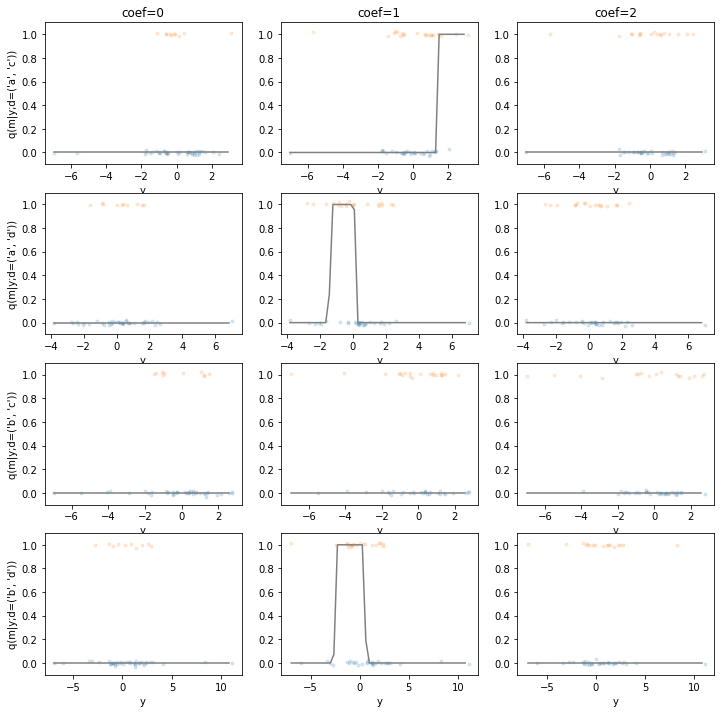

In [6]:
make_training_data_plot(plot_data)

We could now run the experiment, extend `data_so_far`, and get the next trial like so:

In [7]:
data_so_far2 = extend_df_with_result(formula, metadata, data_so_far, design, result=2.0)
data_so_far2

,y,x1,x2
0,2.0,a,d


In [8]:
_, _, _, plot_data2 = next_trial(formula, model_desc, data_so_far2, metadata)

warmup:   4%|▍         | 3/75 [00:00<00:02, 25.72it/s, step size=1.60e-01, acc. prob=0.456]

Running HMC...


sample: 100%|██████████| 75/75 [00:01<00:00, 39.62it/s, step size=4.99e-01, acc. prob=0.541]


100 | 2.1600046157836914
200 | 2.160013437271118
300 | 2.251457452774048
400 | 2.2593793869018555
500 | 2.2599399089813232
600 | 2.2599873542785645
700 | 2.259993553161621
800 | 2.259995937347412
900 | 2.2599968910217285
1000 | 2.259997606277466
eig: 2.259997606277466
all zero would yield: 2.1600000858306885
100 | 2.1599998474121094
200 | 2.1599998474121094
300 | 2.1599998474121094
400 | 2.1599998474121094
500 | 2.1599998474121094
600 | 2.1599998474121094
700 | 2.1599998474121094
800 | 2.1599998474121094
900 | 2.1599998474121094
1000 | 2.1599998474121094
eig: 2.1599998474121094
all zero would yield: 2.1600000858306885
100 | 2.1600000858306885
200 | 2.1600000858306885
300 | 2.1600003242492676
400 | 2.1600005626678467
500 | 2.160000801086426
600 | 2.160003662109375
700 | 2.1995232105255127
800 | 2.199889659881592
900 | 2.199944257736206
1000 | 2.199965000152588
eig: 2.199965000152588
all zero would yield: 2.1600000858306885
100 | 2.2776243686676025
200 | 2.2796168327331543
300 | 2.279841

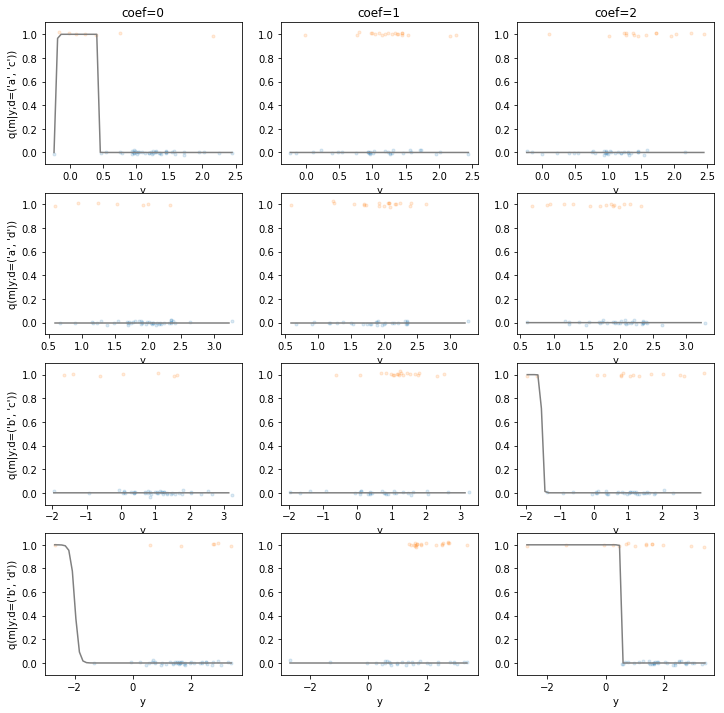

In [9]:
make_training_data_plot(plot_data2)